## Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install munch

In [ ]:
%cd /content/drive/MyDrive/LVM-Med/AI24_LVM-MED

/content/drive/MyDrive/LVM-Med/AI24_LVM-MED


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.transform import resize
import torch
import torchvision.models as models
import torchvision
import torch.nn as nn

In [29]:
# dataset_dir = '/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/dataset_demo/Kvasir_capsule/Training/Kvasir_capsule'
# class_names = os.listdir(dataset_dir)
# print(class_names)

class_names= ['Angiectasia', 'Blood - fresh', 'Erosion', 'Erythema', 'Foreign body', 'Ileocecal valve', 'Lymphangiectasia', 'Normal clean mucosa', 'Pylorus', 'Reduced mucosal view', 'Ulcer']
print(class_names)

['Angiectasia', 'Blood - fresh', 'Erosion', 'Erythema', 'Foreign body', 'Ileocecal valve', 'Lymphangiectasia', 'Normal clean mucosa', 'Pylorus', 'Reduced mucosal view', 'Ulcer']


In [25]:
def loadModel(frozen_encoder, architecture_type, num_classes, dataset_name):
    # Define the ResNet50 model
    model = torchvision.models.resnet50(pretrained=True)

    # Freeze the layers of the ResNet50 model
    if frozen_encoder:
        print ("Frozen encoder")
        for param in model.parameters():
            param.requires_grad = False

    num_ftrs = model.fc.in_features

    # define linear or non-linear architecture
    if architecture_type == '1-fcn':
        print ("Using single fully-connected layer")
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif architecture_type == "fcns":
        print("Using several fully-connected layers")
        if dataset_name == 'brain':
            model.fc = nn.Sequential(
                                  nn.Linear(num_ftrs, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, num_classes))
        elif dataset_name == 'fgadr':
            model.fc = nn.Sequential(
                                  nn.Linear(num_ftrs, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 128),
                                  nn.ReLU(),
                                  nn.Linear(128, num_classes))
        elif dataset_name == 'kvasir_capsule':
            model.fc = nn.Sequential(
                                  nn.Linear(num_ftrs, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 256),
                                  nn.ReLU(),
                                  nn.Linear(256, num_classes))
        else:
            print(">>> Not implemented for selected datasets")
            exit()
    else:
        print (">>> No available option for achitecture. Please check 'help' with --linear option")
        exit()

    return model

In [26]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# Define function for preprocessing images
def preprocess(image, img_size):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize(image, (img_size, img_size), anti_aliasing=True)
    image = np.transpose(image, (2, 0, 1))  # Reshape to (C, H, W)
    image = torch.from_numpy(image).float() / 255.0  # Convert to tensor and normalize
    return image

def plot_img(img, label, size=(10, 10), is_rgb=True):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class: {label}")
    plt.show()

# Assuming your dataset is structured with subdirectories for each class
dataset_dir = '/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/dataset_demo/Kvasir_capsule/Training/Kvasir_capsule'
class_names = os.listdir(dataset_dir)

def demo(image_path, path_of_weight):
    # Preprocess the image
    image = preprocess(image_path, 224)  #
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    dataset_name='kvasir_capsule'
    # Load pre-trained LVM-Med model
    # kvasir_capsule_1-fcn_lvm-med-resnet_output_frozen
    model = loadModel(frozen_encoder = True,architecture_type= '1-fcn',num_classes=len(class_names),dataset_name=dataset_name)  # Initialize the model without pre-trained weights
    pretrained_weight = torch.load(path_of_weight, map_location=device)
    model.load_state_dict(pretrained_weight, strict=False)
    model = model.to(device)
    model.eval()

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    learning_rate=0.001
    solver='adam'
    if solver == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif solver == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08,
                                     weight_decay=0.)
        if dataset_name == 'fgadr':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08,
                                         weight_decay=0.005)
    else:
        print ("Non-available solver")
        exit()

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    # Get the predicted class label using the class_names list
    pred_label = class_names[preds[0]]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    # Display the image and predicted label
    plot_img(image, pred_label)



# # Specify the path to your test dataset
# dataset_path = '/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/notebook/image_demo/kvasir/test'
# demo(dataset_path)

cpu


Frozen encoder
Using single fully-connected layer
(336, 336, 3)


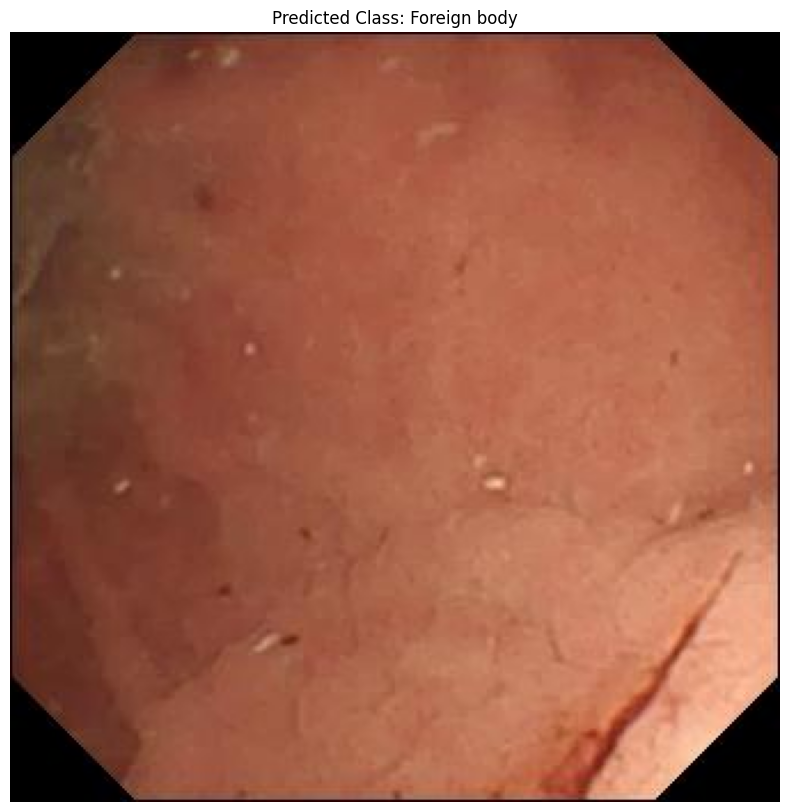

In [34]:
# Specify the path to your test image and pre-trained LVM-Med model weights
path_of_weight = '/content/drive/MyDrive/Data/AI_Advanced/weights_pretrain_lvm/kvasir_capsule_1-fcn_lvm-med-resnet_output_frozen/lvm-med-resnet_output_lvm-med-resnet_1.pth'
image_path = '/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/notebook/image_demo/kvasir/test/cju5xjn5mm78b09871spyqhhr.jpg'
image_path='/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/dataset_demo/Kvasir_capsule/Testing/Kvasir_capsule/Blood - fresh/04a78ef00c5245e0_11213.jpg'
demo(image_path, path_of_weight)

In [55]:
def plot_imgs(images, labels, size=(3, 3)):
    n_images = len(images)
    ncols = 3  # Number of columns in the grid
    nrows = (n_images + ncols - 1) // ncols  # Number of rows in the grid

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * size[0], nrows * size[1]))
    axes = axes.ravel()

    for i in range(n_images):
        img = images[i]  # Remove any extra dimensions and rearrange to (H, W, C)
        axes[i].imshow(img)
        axes[i].set_title(f"Predicted Class: {labels[i]}")
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [51]:
def predict_images(image_paths, path_of_weight):
    # Load pre-trained LVM-Med model
    dataset_name='kvasir_capsule'
    # Load pre-trained LVM-Med model
    # kvasir_capsule_1-fcn_lvm-med-resnet_output_frozen
    model = loadModel(frozen_encoder = True,architecture_type= '1-fcn',num_classes=len(class_names),dataset_name=dataset_name)  # Initialize the model without pre-trained weights
    pretrained_weight = torch.load(path_of_weight, map_location=device)
    model.load_state_dict(pretrained_weight, strict=False)
    model = model.to(device)
    model.eval()

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    learning_rate=0.001
    solver='adam'
    if solver == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif solver == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08,
                                     weight_decay=0.)
        if dataset_name == 'fgadr':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08,
                                         weight_decay=0.005)
    else:
        print ("Non-available solver")
        exit()

    images = []
    labels = []

    for image_path in image_paths:
        # Preprocess the image
        image = preprocess(image_path, 224)  # Adjust input size if necessary
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        # Forward pass through the model
        with torch.no_grad():
            outputs = model(image)
            _, preds = torch.max(outputs, 1)

        # Get the predicted class label using the class_names list
        pred_label = class_names[preds[0]]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (20, 20))
        images.append(image)
        labels.append(pred_label)

    # Display the images and predicted labels
    plot_imgs(images, labels)

In [48]:


image_path='/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/notebook/image_demo/kvasir/demo'

filenames = os.listdir(image_path)

image_paths = [os.path.join(image_path, filename) for filename in filenames]
image_paths
# demo(image_path, path_of_weight)

['/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/notebook/image_demo/kvasir/demo/3ada4222967f421d_5924.jpg',
 '/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/notebook/image_demo/kvasir/demo/7a47e8eacea04e64_2034.jpg',
 '/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/notebook/image_demo/kvasir/demo/3ada4222967f421d_5951.jpg',
 '/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/notebook/image_demo/kvasir/demo/04a78ef00c5245e0_12364.jpg',
 '/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/notebook/image_demo/kvasir/demo/7ad22d50ebaf4596_10464.jpg',
 '/content/drive/MyDrive/LVM-Med/AI24_LVM-MED/notebook/image_demo/kvasir/demo/7a47e8eacea04e64_2045.jpg']

Frozen encoder
Using single fully-connected layer


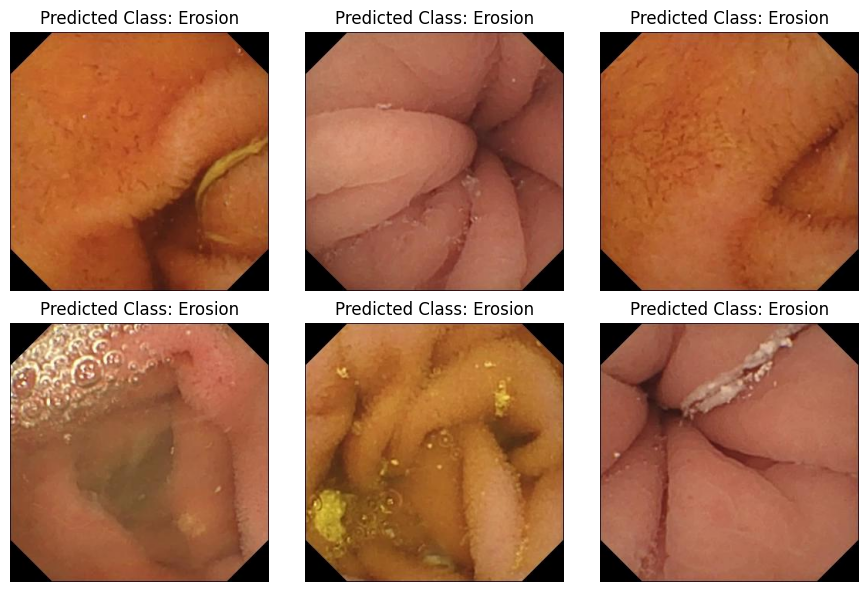

In [60]:
predict_images(image_paths, path_of_weight)